In [1]:
import numpy as np
import matplotlib.pyplot as plt

import petitRADTRANS.poor_mans_nonequ_chem as pm

[-6.  0.  2.]


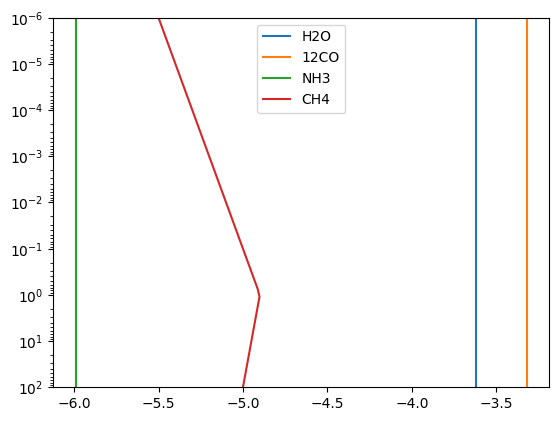

In [25]:
from scipy.interpolate import make_interp_spline

class Chemistry:

    # Dictionary with info per molecular/atomic species
    # (line_species name, mass, number of (C,O,H) atoms
    species_info = {
        '12CO': ('CO_main_iso', 12.011 + 15.999, (1,1,0)), 
        #'12CO': ('CO_high', 12.011 + 15.999, (1,1,0)), 
        'H2O': ('H2O_pokazatel_main_iso', 2*1.00784 + 15.999, (0,1,2)), 
        'CH4': ('CH4_hargreaves_main_iso', 12.011 + 4*1.00784, (1,0,4)), 
        '13CO': ('CO_36', 13.003355 + 15.999, (1,1,0)), 
        #'13CO': ('CO_36_high', 13.003355 + 15.999, (1,1,0)), 
        'C18O': ('CO_28', 12.011 + 17.9991610, (1,1,0)), 
        'H2O_181': ('H2O_181', 2*1.00784 + 17.9991610, (0,1,2)), 
        'NH3': ('NH3_coles_main_iso', 14.0067 + 3*1.00784, (0,0,3)), 
        'CO2': ('CO2_main_iso', 12.011 + 2*15.999, (1,2,0)),
        'HCN': ('HCN_main_iso', 1.00784 + 12.011 + 14.0067, (1,0,1)), 
        'He': ('He', 4.002602, (0,0,0)), 
        'H2': ('H2', 2*1.00784, (0,0,2)), 
        }

    species_plot_info = {
        '12CO': ('C2', r'$^{12}$CO'), 
        'H2O': ('C3', r'H$_2$O'), 
        'CH4': ('C4', r'CH$_4$'), 
        #'13CO': ('C5', r'$^{13}$CO'), 
        '13CO': ('chocolate', r'$^{13}$CO'), 
        'C18O': ('C6', r'C$^{18}$O'), 
        'H2O_181': ('C7', r'H$_2^{18}$O'), 
        'NH3': ('C8', r'NH$_3$'), 
        'CO2': ('C9', r'CO$_2$'),
        'HCN': ('C10', r'HCN'), 
        }

    # Neglect certain species to find respective contribution
    neglect_species = {
        '12CO': False, 
        'H2O': False, 
        'CH4': False, 
        '13CO': False, 
        'C18O': False, 
        'H2O_181': False, 
        'NH3': False, 
        'CO2': False,
        'HCN': False, 
        #'He': False, 
        #'H2': False, 
        }

    def __init__(self, line_species, pressure):

        self.line_species = line_species

        self.pressure     = pressure
        self.n_atm_layers = len(self.pressure)

    def remove_species(self, species):

        # Remove the contribution of the specified species
        for species_i in species:
            
            # Read the name of the pRT line species
            line_species_i = self.read_species_info(species_i, 'pRT_name')

            # Set mass fraction to negligible values
            # TODO: does 0 work?
            if line_species_i in self.line_species:
                self.mass_fractions[line_species_i] = 0

    @classmethod
    def read_species_info(cls, species, info_key):
        
        if info_key == 'pRT_name':
            return cls.species_info[species][0]
        elif info_key == 'mass':
            return cls.species_info[species][1]
        elif info_key == 'C':
            return cls.species_info[species][2][0]
        elif info_key == 'O':
            return cls.species_info[species][2][1]
        elif info_key == 'H':
            return cls.species_info[species][2][2]

        elif info_key == 'c' or info_key == 'color':
            return cls.species_plot_info[species][0]
        elif info_key == 'label':
            return cls.species_plot_info[species][1]

class FreeChemistry(Chemistry):

    def __init__(self, line_species, pressure, spline_order=1):

        # Give arguments to the parent class
        super().__init__(line_species, pressure)

        self.spline_order = spline_order

    def __call__(self, VMRs, params):

        self.VMRs = VMRs

        # Total VMR without H2, starting with He
        VMR_He = 0.15
        VMR_wo_H2 = 0 + VMR_He

        # Create a dictionary for all used species
        self.mass_fractions = {}

        C, O, H = 0, 0, 0
        for species_i, (line_species_i, mass_i, COH_i) in self.species_info.items():

            if species_i in ['H2', 'He']:
                continue

            if line_species_i in self.line_species:

                if self.VMRs.get(species_i) is not None:
                    # Single value given: constant, vertical profile
                    VMR_i = self.VMRs[species_i] * np.ones(self.n_atm_layers)
                else:
                    # Multiple values given, use spline interpolation

                    # Define the spline knots in pressure-space
                    if params.get(f'log_P_{species_i}') is not None:
                        log_P_knots = np.array([
                            np.log10(self.pressure).min(), params[f'log_P_{species_i}'], 
                            np.log10(self.pressure).max()
                            ])
                    else:
                        log_P_knots = np.linspace(
                            np.log10(self.pressure).min(), 
                            np.log10(self.pressure).max(), num=3
                            )
                    
                    # Define the abundances at the knots
                    VMR_knots = np.array([self.VMRs[f'{species_i}_{j}'] for j in range(3)])[::-1]
                    
                    # Use a k-th order spline to vary the abundance profile
                    spl = make_interp_spline(log_P_knots, VMR_knots, k=self.spline_order)
                    VMR_i = spl(np.log10(self.pressure))

                self.VMRs[species_i] = VMR_i

                # Convert VMR to mass fraction using molecular mass number
                self.mass_fractions[line_species_i] = mass_i * VMR_i
                VMR_wo_H2 += VMR_i

                # Record C, O, and H bearing species for C/O and metallicity
                C += COH_i[0] * VMR_i
                O += COH_i[1] * VMR_i
                H += COH_i[2] * VMR_i

        # Add the H2 and He abundances
        self.mass_fractions['He'] = self.read_species_info('He', 'mass') * VMR_He
        self.mass_fractions['H2'] = self.read_species_info('H2', 'mass') * (1 - VMR_wo_H2)

        # Add to the H-bearing species
        H += self.read_species_info('H2', 'H') * (1 - VMR_wo_H2)

        if VMR_wo_H2.any() > 1:
            # Other species are too abundant
            self.mass_fractions = -np.inf
            return self.mass_fractions

        # Compute the mean molecular weight from all species
        MMW = 0
        for mass_i in self.mass_fractions.values():
            MMW += mass_i
        MMW *= np.ones(self.n_atm_layers)

        # Turn the molecular masses into mass fractions
        for line_species_i in self.mass_fractions.keys():
            self.mass_fractions[line_species_i] /= MMW

        # pRT requires MMW in mass fractions dictionary
        self.mass_fractions['MMW'] = MMW

        # Compute the C/O ratio and metallicity
        self.CO = C/O

        log_CH_solar = 8.43 - 12 # Asplund et al. (2009)
        self.FeH = np.log10(C/H) - log_CH_solar
        self.CH  = self.FeH

        self.CO = np.mean(self.CO)
        self.FeH = np.mean(self.FeH)
        self.CH = np.mean(self.CH)

        for species_i in self.neglect_species:
            if self.neglect_species[species_i]:
                line_species_i = self.read_species_info(species_i, 'pRT_name')

                # Set abundance to 0 to evaluate species' contribution
                self.mass_fractions[line_species_i] *= 0

        return self.mass_fractions

Chem = FreeChemistry(
    line_species=[
        'H2O_pokazatel_main_iso', 
        'CO_main_iso', 
        'CH4_hargreaves_main_iso', 
        'NH3_coles_main_iso'
        ], 
    pressure=np.logspace(-6,2,50), 
    spline_order=1
    )

VMRs = {
    'H2O': -3.62, 
    '12CO': -3.32, 
    'CH4_0': -5., 'CH4_1': -4.9, 'CH4_2': -5.5, 
    'NH3': -5.99, 
    }

params = {'log_P_CH4':0}

Chem(VMRs=VMRs, params=params)

for key in Chem.VMRs.keys():
    
    if isinstance(Chem.VMRs[key], np.ndarray):
        plt.plot(Chem.VMRs[key], Chem.pressure, label=key)

plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e2,1e-6)
plt.show()

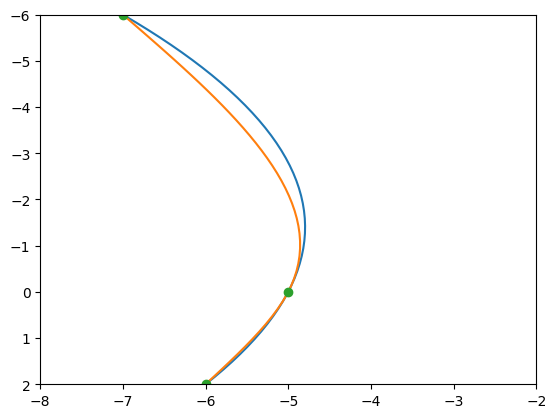

In [32]:
from scipy.interpolate import interp1d, splrep, splev, RegularGridInterpolator#, LinearNDInterpolator
from scipy.interpolate import make_interp_spline

log_P_knots = np.linspace(-6, 2, 3)
log_P_knots = np.array([-6,0,2])
y = np.array([-7,-5,-6])
#log_P_knots = np.linspace(-6, 2, 2)
#y = np.array([-7,-6])

pressure = np.logspace(-6, 2, 50)

spl = make_interp_spline(log_P_knots, y, k=2)#bc_type='not-a-knot')
plt.plot(spl(np.log10(pressure)), np.log10(pressure))

spl = make_interp_spline(log_P_knots, y, k=3, bc_type='natural')
plt.plot(spl(np.log10(pressure)), np.log10(pressure))

plt.plot(y, log_P_knots, 'o')
plt.ylim(2, -6)
plt.xlim(-8,-2)
plt.show()